In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchlake.image_generation.controllers.trainer_pixelcnn import PixelCNNTrainer
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_num_workers
from torchlake.image_generation.models.pixelrnn import PixelRNN
from torchvision import transforms
from tqdm import tqdm

# Setting

In [2]:
IMAGE_SIZE = 28
BATCH_SIZE = 32

In [3]:
artifact_path = Path("../../artifacts/pixelrnn")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/mnist")

In [4]:
DEVICE = torch.device("cuda:0")

# Data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [6]:
train_data = torchvision.datasets.MNIST(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
    download=True,
)

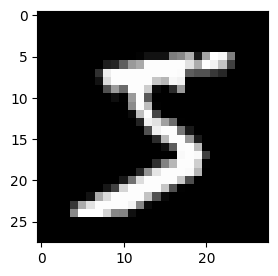

In [7]:
plt.figure(figsize=(3, 3))
plt.imshow(img_tensor_to_np(train_data[0][0]), cmap="gray")

In [8]:
def collate_fn(batch):
    x, y = [], []
    for img, _ in batch:
        x.append(img)
        y.append(img)
        
    return torch.stack(x), torch.stack(y).mul_(255).long().view(-1, IMAGE_SIZE, IMAGE_SIZE)

In [9]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=collate_fn,
    num_workers=get_num_workers(),
)

In [10]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([32, 1, 28, 28]) torch.Size([32, 28, 28])


# Model

In [11]:
import torchinfo

In [24]:
model = PixelRNN(
    1,
    256,
    hidden_dim=128,
    num_layer=12,
    rnn_type="row",
)

In [25]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
PixelRNN                                      --
├─Sequential: 1-1                             --
│    └─MaskedConv2d: 2-1                      12,800
├─Sequential: 1-2                             --
│    └─ResBlock: 2-2                          --
│    │    └─ReLU: 3-1                         --
│    │    └─BottleNeck: 3-2                   623,872
│    │    └─Identity: 3-3                     --
│    └─ResBlock: 2-3                          (recursive)
│    │    └─ReLU: 3-4                         --
│    │    └─BottleNeck: 3-5                   (recursive)
│    │    └─Identity: 3-6                     --
│    └─ResBlock: 2-4                          (recursive)
│    │    └─ReLU: 3-7                         --
│    │    └─BottleNeck: 3-8                   (recursive)
│    │    └─Identity: 3-9                     --
│    └─ResBlock: 2-5                          (recursive)
│    │    └─ReLU: 3-10                        --
│    │    

In [12]:
model = PixelRNN(
    1,
    256,
    hidden_dim=32,
    num_layer=6,
    rnn_type="diag",
)

In [13]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
PixelRNN                                           --
├─Sequential: 1-1                                  --
│    └─MaskedConv2d: 2-1                           3,200
├─Sequential: 1-2                                  --
│    └─ResBlock: 2-2                               --
│    │    └─ReLU: 3-1                              --
│    │    └─BottleNeck: 3-2                        35,392
│    │    └─Identity: 3-3                          --
│    └─ResBlock: 2-3                               (recursive)
│    │    └─ReLU: 3-4                              --
│    │    └─BottleNeck: 3-5                        (recursive)
│    │    └─Identity: 3-6                          --
│    └─ResBlock: 2-4                               (recursive)
│    │    └─ReLU: 3-7                              --
│    │    └─BottleNeck: 3-8                        (recursive)
│    │    └─Identity: 3-9                          --
│    └─ResBlock: 2-5              

# train

## RowLSTM


In [13]:
EPOCH = 10

In [14]:
trainer = PixelCNNTrainer(EPOCH, DEVICE)

In [15]:
trainer.recorder.increment_data_size(len(train_data))

In [16]:
criterion = trainer.get_criterion(256)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [37]:
scaler = torch.amp.GradScaler()

In [18]:
training_loss = trainer.run(train_loader, model, optim, criterion, scaler=scaler)

Enable AMP: True
Training...


100%|██████████| 1875/1875 [18:16<00:00,  1.71it/s]


------------------------------------
Epoch 1
------------------------------------
0.026688180769483236 (0%)


100%|██████████| 1875/1875 [18:21<00:00,  1.70it/s]


------------------------------------
Epoch 2
------------------------------------
0.024340429413318588 (-9%)


100%|██████████| 1875/1875 [15:56<00:00,  1.96it/s]


------------------------------------
Epoch 3
------------------------------------
0.023772309762239482 (-2%)


100%|██████████| 1875/1875 [16:54<00:00,  1.85it/s]


------------------------------------
Epoch 4
------------------------------------
0.023243483184774715 (-2%)


100%|██████████| 1875/1875 [17:14<00:00,  1.81it/s]


------------------------------------
Epoch 5
------------------------------------
0.022901624627908113 (-1%)


100%|██████████| 1875/1875 [18:09<00:00,  1.72it/s]


------------------------------------
Epoch 6
------------------------------------
0.022637690718968703 (-1%)


100%|██████████| 1875/1875 [17:49<00:00,  1.75it/s]


------------------------------------
Epoch 7
------------------------------------
0.022403280034661254 (-1%)


100%|██████████| 1875/1875 [16:52<00:00,  1.85it/s]


------------------------------------
Epoch 8
------------------------------------
0.02209286510348322 (-1%)


100%|██████████| 1875/1875 [16:30<00:00,  1.89it/s]


------------------------------------
Epoch 9
------------------------------------
0.021824350904424968 (-1%)


100%|██████████| 1875/1875 [16:55<00:00,  1.85it/s]

------------------------------------
Epoch 10
------------------------------------
0.021570790870984426 (-1%)


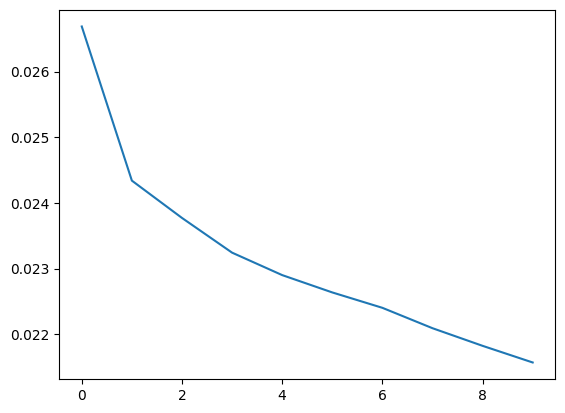

In [19]:
plt.plot(training_loss)

In [20]:
from torchlake.common.controller.weight_manager import WeightManager

manager = WeightManager(artifact_path.joinpath('pixelrnn.d{hidden_dim}.l{num_layer}.{rnn_type}.mnist.pth').as_posix())
model_path = manager.get_filename(hidden_dim=model.hidden_dim, num_layer=model.num_layer, rnn_type=model.rnn_type)

In [21]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\pixelrnn\pixelrnn.d128.l12.row.mnist.pth, model size is 2.76MiB


In [22]:
manager.load_weight(model_path, model)

## Diagonal LSTM


In [14]:
EPOCH = 10

In [15]:
trainer = PixelCNNTrainer(EPOCH, DEVICE)

In [16]:
trainer.recorder.increment_data_size(len(train_data))

In [17]:
criterion = trainer.get_criterion(256)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# scaler = torch.amp.GradScaler()

In [18]:
training_loss = trainer.run(train_loader, model, optim, criterion)

Enable AMP: False
Training...


  0%|          | 0/1875 [00:00<?, ?it/s]

100%|██████████| 1875/1875 [34:53<00:00,  1.12s/it]


------------------------------------
Epoch 1
------------------------------------
0.021899174568057116 (0%)


100%|██████████| 1875/1875 [35:27<00:00,  1.13s/it]


------------------------------------
Epoch 2
------------------------------------
0.015543565627435833 (-29%)


100%|██████████| 1875/1875 [34:52<00:00,  1.12s/it]


------------------------------------
Epoch 3
------------------------------------
0.013888215377926824 (-11%)


100%|██████████| 1875/1875 [34:31<00:00,  1.10s/it]


------------------------------------
Epoch 4
------------------------------------
0.013004374951620887 (-6%)


100%|██████████| 1875/1875 [35:08<00:00,  1.12s/it]


------------------------------------
Epoch 5
------------------------------------
0.012307755321264276 (-5%)


100%|██████████| 1875/1875 [34:06<00:00,  1.09s/it]


------------------------------------
Epoch 6
------------------------------------
0.011623420354723947 (-6%)


100%|██████████| 1875/1875 [34:32<00:00,  1.11s/it]


------------------------------------
Epoch 7
------------------------------------
0.010881532410780582 (-6%)


100%|██████████| 1875/1875 [33:58<00:00,  1.09s/it]


------------------------------------
Epoch 8
------------------------------------
0.010567181735734135 (-3%)


100%|██████████| 1875/1875 [33:38<00:00,  1.08s/it]


------------------------------------
Epoch 9
------------------------------------
0.010046600322425374 (-5%)


100%|██████████| 1875/1875 [33:37<00:00,  1.08s/it]

------------------------------------
Epoch 10
------------------------------------
0.009769855107118685 (-3%)


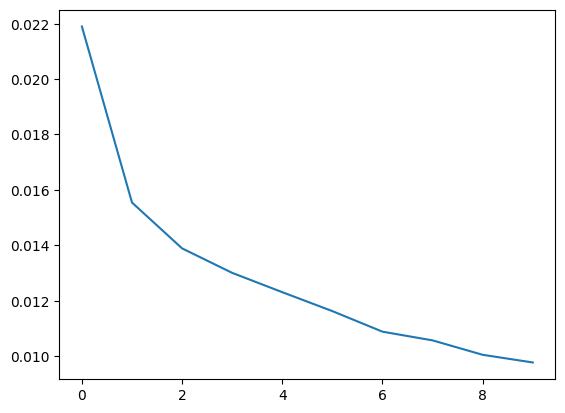

In [19]:
plt.plot(training_loss)

In [14]:
from torchlake.common.controller.weight_manager import WeightManager

manager = WeightManager(artifact_path.joinpath('pixelrnn.d{hidden_dim}.l{num_layer}.{rnn_type}.mnist.pth').as_posix())
model_path = manager.get_filename(hidden_dim=model.hidden_dim, num_layer=model.num_layer, rnn_type=model.rnn_type)

In [21]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\pixelrnn\pixelrnn.d32.l6.diag.mnist.pth, model size is 0.21MiB


In [15]:
manager.load_weight(model_path, model)

# Evaluation

## RowLSTM

In [23]:
TEST_BATCH_SIZE = 16

784it [01:11, 10.98it/s]


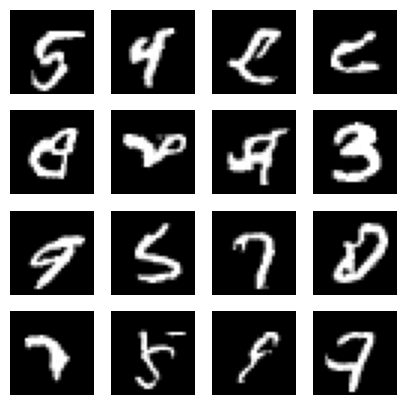

In [26]:
from itertools import product

model.eval()
with torch.no_grad():
    placeholder = torch.zeros(TEST_BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)
    
    for i, j, c in tqdm(product(range(IMAGE_SIZE), range(IMAGE_SIZE), range(1))):
        # only subsecond level speed up for smaller placeholder
        dist = model(placeholder[:, :, :(i+1)])[:, c, :, i, j].softmax(1)
        placeholder[:, c, i, j] = torch.multinomial(dist, 1).squeeze_(-1).float() / 255.0
                
plot_grids(
    img_tensor_to_np(placeholder), 
    cmap='gray',
    num_col=4,
    num_row=4,
    figsize=(5,5),
)

## Diagonal LSTM

In [ ]:
TEST_BATCH_SIZE = 16

In [18]:
model = model.to(DEVICE)

784it [03:53,  3.35it/s]


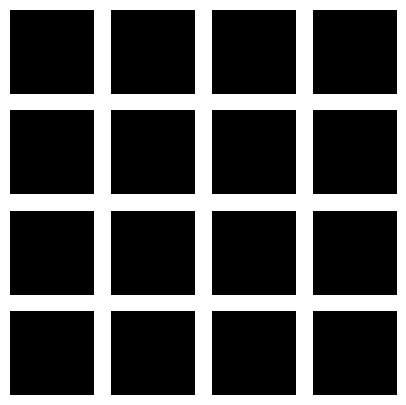

In [19]:
from itertools import product

model.eval()
with torch.no_grad():
    placeholder = torch.zeros(TEST_BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)
    
    for i, j, c in tqdm(product(range(IMAGE_SIZE), range(IMAGE_SIZE), range(1))):
        # only subsecond level speed up for smaller placeholder
        dist = model(placeholder)[:, c, :, i, j].softmax(1)
        placeholder[:, c, i, j] = torch.multinomial(dist, 1).squeeze_(-1).float() / 255.0
                
plot_grids(
    img_tensor_to_np(placeholder), 
    cmap='gray',
    num_col=4,
    num_row=4,
    figsize=(5,5),
)